### Using Yuzu with Your Model

A challenge in using Yuzu is that replacing operations within a graph is somewhat difficult to implement efficiently: not only do the convolution and max-pool operations need to be rewritten, but the precomputed metadata needs to be passed into layers as appropriate. Accordingly, Yuzu's implementation ignores the forward pass in the written model and instead iterates over the layers in the `model.children()` generator, applying or replacing them as necessary.

This notebook will show how to use Yuzu in practice. First, we will show some of the limitations that Yuzu has. Then, we will show how to overcome many of these limitations easily.

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')
import torch

Populating the interactive namespace from numpy and matplotlib


### Limitations of Yuzu

Unfortunately, iterating over `model.children()` is conceptually easy but requires that the models are sequential. A major consequence of this is that no multi-input or multi-output networks are supported right now (unless the inputs or outputs can be represented in a single tensor). Also, no networks with multiple paths are supported right now, including residual connections. 

A second type of limitation is that no operations can be performed in the forward pass other than iterating through the layers in a sequential manner. This means no flattening, reshaping, cropping, adding operations, referring to the same layer multiple times, etc. Any manipulation of the data must occur within the context of layers.

Let's start off with a minimal implementation of a small BPNet model, implemented as one might without considering these constraints.

In [2]:
import torch

class BPNet(torch.nn.Module):
    def __init__(self, n_filters=64, n_layers=3):
        super(BPNet, self).__init__()
        self.trimming = 2 ** n_layers + 3
        self.n_filters = n_filters
        self.n_layers = n_layers

        self.iconv = torch.nn.Conv1d(4, n_filters, kernel_size=7, padding=3)
        self.rconvs = torch.nn.ModuleList([
            torch.nn.Conv1d(n_filters, n_filters, kernel_size=3, padding=2**i, dilation=2**i) for i in range(1, self.n_layers+1)
        ])

        self.fconv = torch.nn.Conv1d(n_filters, 1, kernel_size=7, padding=3)
        self.relu = torch.nn.ReLU()
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming
        X = self.relu(self.iconv(X))
        for i in range(self.n_layers):
            X_conv = self.relu(self.rconvs[i](X))
            X = torch.add(X, X_conv)

        X = self.fconv(X)
        X = X[:, :, start:end]
        y_profile = self.logsoftmax(X) 
        return y_profile

Unfortunately, using Yuzu requires that a few things need to be changed in this implementation. The first is that ModuleList layer needs to be flattened out. The second is that each ReLU has to be explicitly written rather than having a single ReLU object referenced multiple times. Next, the cropping operation has to be moved into an explicit layer that performs cropping and is specified in the `__init__` method. Finally, and most unfortunately, residual operations are not currently supported by Yuzu.

Here is what a model that would work for Yuzu would look like:

In [3]:
class Crop(torch.nn.Module):
    def __init__(self, trimming):
        super(Crop, self).__init__()
        self.trimming = trimming
    
    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming
        return X[:, :, start:end]

class BPNet2(torch.nn.Module):
    def __init__(self, n_filters=64, n_layers=3):
        super(BPNet2, self).__init__()
        self.trimming = 2 ** n_layers + 3
        self.n_filters = n_filters
        self.n_layers = n_layers

        self.iconv = torch.nn.Conv1d(4, n_filters, kernel_size=7, padding=3)
        self.relu1 = torch.nn.ReLU()
        
        self.rconv1 = torch.nn.Conv1d(n_filters, n_filters, kernel_size=3, padding=2, dilation=2)
        self.relu2 = torch.nn.ReLU()
        
        self.rconv2 = torch.nn.Conv1d(n_filters, n_filters, kernel_size=3, padding=4, dilation=4)
        self.relu3 = torch.nn.ReLU()
        
        self.rconv3 = torch.nn.Conv1d(n_filters, n_filters, kernel_size=3, padding=8, dilation=8)
        self.relu4 = torch.nn.ReLU()
        
        self.fconv = torch.nn.Conv1d(n_filters, 1, kernel_size=7, padding=3)
        self.crop = Crop(self.trimming)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, X):
        X = self.relu1(self.iconv(X))
        X = self.relu2(self.rconv1(X))
        X = self.relu3(self.rconv2(X))
        X = self.relu4(self.rconv3(X))
        X = self.fconv(X)
        X = self.crop(X)
        X = self.logsoftmax(X)
        return X
    
model = BPNet2()

Given this model, we can run through the Yuzu pipeline just as before. All we have to do is make sure that the custom layers are passed in as terminal layers if you need to stop usin the delta tensor representation internally and instead stop running the Yuzu procedure once the layer is encountered.

In [4]:
from yuzu import yuzu_ism, precompute

seq_len = 500

precomputation = precompute(model, seq_len, alpha=1.05, terminal_layers=(Crop,))

In [5]:
idxs = numpy.random.RandomState(0).randn(4, seq_len).argmax(axis=0)
X = numpy.zeros((1, 4, seq_len), dtype='float32')
X[0, idxs, numpy.arange(seq_len)] = 1

%timeit yuzu_ism(model, X, precomputation, terminal_layers=(Crop,))

861 ms ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


And we can compare the time to the naive ISM method. 

In [6]:
from yuzu.naive_ism import naive_ism

%timeit naive_ism(model, X)

3.19 s ± 215 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


And we can get the scores as normal. Just make sure to pass in the custom layer as a terminal layer.

In [7]:
yuzu_ism_scores = yuzu_ism(model, X, precomputation, terminal_layers=(Crop,))
naive_ism_scores = naive_ism(model, X)

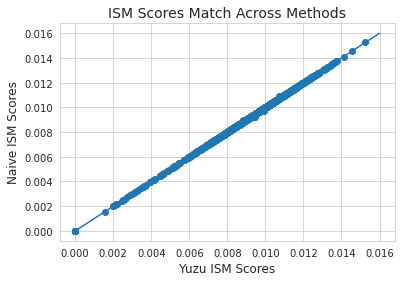

In [8]:
plt.scatter(yuzu_ism_scores.flatten(), naive_ism_scores.flatten())
plt.plot([0, 0.016], [0, 0.016])
plt.title("ISM Scores Match Across Methods", fontsize=14)
plt.xlabel("Yuzu ISM Scores", fontsize=12)
plt.ylabel("Naive ISM Scores", fontsize=12)
plt.show()

Finally, we can confirm that we get the same ISM scores using Yuzu and the naive method on this model.

In [9]:
numpy.abs(naive_ism_scores - yuzu_ism_scores).mean()

1.3223429e-06

### Using Yuzu with a Pre-trained Model

Now, let's say that you've already trained your model and you don't want to have to rewrite and retrain your model just to use Yuzu. Fortunately, you can usually transfer the weights of the learned parameters over to a new model definition that includes the changes that you need.

For instance, let's say you've trained a DeepSEA model with the following implementation:

In [10]:
class DeepSEA(torch.nn.Module):
    def __init__(self, random_state=0):
        super(DeepSEA, self).__init__()
        torch.manual_seed(random_state)

        self.conv1 = torch.nn.Conv1d(4, 32, kernel_size=9, padding=4)
        self.relu1 = torch.nn.ReLU()
        self.mp1 = torch.nn.MaxPool1d(4)

        self.conv2 = torch.nn.Conv1d(32, 48, kernel_size=9, padding=4)
        self.relu2 = torch.nn.ReLU()
        self.mp2 = torch.nn.MaxPool1d(4)

        self.conv3 = torch.nn.Conv1d(48, 96, kernel_size=9, padding=4)
        self.relu3 = torch.nn.ReLU()

        self.fc = torch.nn.Linear((250 // 4 // 4) * 96, 925)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        X = self.mp1(self.relu1(self.conv1(X)))
        X = self.mp2(self.relu2(self.conv2(X)))
        X = self.relu3(self.conv3(X))
        X = X.permute(0, 2, 1).contiguous().view(X.shape[0], -1)

        X = self.sigmoid(self.fc(X))
        X = X.unsqueeze(1)
        return X
    
model = DeepSEA()

In order to get a model trained with this implementation to work with Yuzu, all we need to do is redefine the implementation with the fixes and transfer the weights over as appropriate. 

First, let's write out an implementation that would work with Yuzu using two built-in layers for common operations.

In [11]:
from yuzu.models import Flatten, Unsqueeze

class DeepSEA2(torch.nn.Module):
    def __init__(self, random_state=0):
        super(DeepSEA2, self).__init__()
        torch.manual_seed(random_state)

        self.conv1 = torch.nn.Conv1d(4, 32, kernel_size=9, padding=4)
        self.relu1 = torch.nn.ReLU()
        self.mp1 = torch.nn.MaxPool1d(4)

        self.conv2 = torch.nn.Conv1d(32, 48, kernel_size=9, padding=4)
        self.relu2 = torch.nn.ReLU()
        self.mp2 = torch.nn.MaxPool1d(4)

        self.conv3 = torch.nn.Conv1d(48, 96, kernel_size=9, padding=4)
        self.relu3 = torch.nn.ReLU()

        self.flatten = Flatten()
        self.fc = torch.nn.Linear((250 // 4 // 4) * 96, 925)
        self.sigmoid = torch.nn.Sigmoid()
        self.unsqueeze = Unsqueeze(1)

    def forward(self, X):
        X = self.mp1(self.relu1(self.conv1(X)))
        X = self.mp2(self.relu2(self.conv2(X)))
        X = self.relu3(self.conv3(X))
        X = self.flatten(X)

        X = self.sigmoid(self.fc(X))
        X = self.unsqueeze(X)
        return X

Now, let's create an instance of the new model and transfer the parameters over.

In [12]:
model2 = DeepSEA2()
model2.load_state_dict(model.state_dict())

<All keys matched successfully>

We can demonstrate that the outputs from the model are the same:

In [13]:
idxs = numpy.random.RandomState(0).randn(4, 250).argmax(axis=0)
X = numpy.zeros((1, 4, 250), dtype='float32')
X[0, idxs, numpy.arange(250)] = 1
X_torch = torch.tensor(X)

x = model(X_torch).detach().numpy()
y = model2(X_torch).detach().numpy()

numpy.abs(x - y).sum()

/users/jmschr/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


0.0

We can also show that the naive ISM outputs are the same for both models, and that the Yuzu ISM output matches the naive ISM one.

In [14]:
nism1 = naive_ism(model, X)
nism2 = naive_ism(model2, X)

precomputation = precompute(model2, 250)
yism = yuzu_ism(model2, X, precomputation)

numpy.abs(nism1 - nism2).sum(), numpy.abs(yism - nism2).sum()

(0.0, 0.00016033882)

Transferring weights over like this offers great flexibility in re-defining the model to match the Yuzu specifications for now.